###  Introduction： 
    
This is a notebook documenting a bunch of code implementations for geospatial data analysis on a minor use case of transport data research problem. It is simulating an operational setting of Point-to-Point Pick-up and Delivery (PPD) service, or synonymously called a dial-a-ride service, such that a demand of customers making appointments to schedule a trip between their requested on-and-off locations. The transport planning units may be interested to know: 
    <ol>
    <li> spatial patterns or distributions of the daily source of passengers and the frequently visited public amenities; whether there are spatial clusters detected, or where the high-density and low-density clusters are located; etc. </li><br>
    <li> efficient ways of allocation and scheduling of the vehicle resources or capitals to fulfill all the demands with minimal travelling distances (which is proportional to the operating costs); </li><br>
    </ol>
This first one could be ascribed to a transportation geography problem that is associated with urban political concerns; while the second one would be of more emphasis from the operations research perspective. Here, to reconstruct a similar process, I follow a series of steps to gather open-sourced Green Mini-bus (a public transport) data from the official platform of a Hong Kong Open Data Hub (https://www.data.gov.hk), using API services.
    <ol>
    <li> scrap all green minibus routes running in Kowloon and the corresponding stops of each route </li><br>
    <li> gather all stops to form a pool of representative spots, and then judging by the name of the stops (Chinese and English), annotate if a single stop can be near a residential address, or a public amenities (a venue related to education, healthcare, elderly or disability care, governmental institutions) </li><br>
    <li> randomly sample one spot from the residential address stops (regarded for its likelihood as a starting point) and one stop from the public facility stops (regarded for its likelihood as an ending point); this will constitute to an individual trip of a typical passenger who has a need of travel for his/her daily activities </li><br>
    <li> repeat the random sampling process to get a number of trips (e.g., 2000) to form a dataset </li><br>
    <li> since the points are randomly sampled, the starting and ending pairs were not necessarily connected with an existing bus route, for delineating a route on the map and calculating the travel distance of the trips, the OpenSreetMap road network specific for Kowloon, HKSAR would be downloaded from the "osmnx" package, in which the distance provided can be chosen to optimize on path lengths or travelling time required. </li><br>
    </ol> 

In [1]:
import requests
import json
import os
import re
import random
import copy
import pandas as pd
import numpy as np

###  1)  Green-minibus APIs, OpenStreetMap road network APIs, simulation dataset：

In [ ]:
##  API to get all Routes
url = "https://data.etagmb.gov.hk/route/KLN"
kln_gmb_routes = requests.request("GET", url)
kln_gmb_routes = json.loads(kln_gmb_routes.content)['data']['routes']

In [ ]:
##  Total number of operating Green-minibus routes in Kowloon
print("Number of Routes: " + str(len(kln_gmb_routes)))

Number of Routes: 131


In [ ]:
# route numbers are returned 
kln_gmb_routes[0:10]

['12', '12A', '12B', '12S', '13', '13A', '13M', '16', '16A', '16B']

In [ ]:
##  API to get all Stops along a Route
route_stops = list()

for r in kln_gmb_routes:
    url = "https://data.etagmb.gov.hk/route/KLN/" + r
    route_data = requests.request("GET", url)
    route_data = json.loads(route_data.content)['data']
    route_ids = [x['route_id'] for x in route_data]

    stop_list = list()
    for rs in route_ids:
        url = "https://data.etagmb.gov.hk/route-stop/" + str(rs) + "/1"
        stops = requests.request("GET", url)
        stops = json.loads(stops.content)['data']['route_stops']
        stop_list.append(stops)

    route_stops.append(stop_list)

In [ ]:
##  Extract stops
stop_ids = list()
stops_extract_tc = list()
stops_extract_en = list()

for n in route_stops:
    for t in n[0]:
        sttc = t['name_tc']
        sten = t['name_en']
        stop_id = t['stop_id']
        stops_extract_tc.append(sttc)
        stops_extract_en.append(sten)
        stop_ids.append(stop_id)


##  Extract all Education / Healthcare / Community Centres / Public (Government) Service points of interest
mark_dest_stops_tc = list()
mark_dest_stops_en = list()

for name in stops_extract_tc:
    if any([x in name for x in ["學","書院","醫","診","療","護理","安老","老人院","社區","管理","服務",
                                "政府","署","局","行政","法院"]]):
        mark_dest_stops_tc.append(1)
    else:
        mark_dest_stops_tc.append(0)

for name in stops_extract_en:
    if any([x in name.lower() for x in ["school","university","college","kindergarten","academy","institute",
                                        "hospital","clinic","care","elderly","therapy","health","nursing",
                                        "community","gov","department","headquarter","office","law court"]]):
        mark_dest_stops_en.append(1)
    else:
        mark_dest_stops_en.append(0)


##  Extract all Residential points of interest
mark_orig_stops_tc = list()
mark_orig_stops_en = list()

for name in stops_extract_tc:
    if any([x in name for x in ["邨","閣","座","苑","大廈","村","花園","宿舍","舍"]]):
        mark_orig_stops_tc.append(1)
    else:
        mark_orig_stops_tc.append(0)

for name in stops_extract_en:
    if any([x in name.lower() for x in ["estate","house","home","court","block","villa","garden","mansion","residence"]]):
        mark_orig_stops_en.append(1)
    else:
        mark_orig_stops_en.append(0)


##   POI data frame
detect_poi_df = pd.DataFrame({"chi_desc": stops_extract_tc,
                              "eng_desc": stops_extract_en,
                              "stop_id": stop_ids,
                              "destination_poi_tc": mark_dest_stops_tc,
                              "destination_poi_en": mark_dest_stops_en,
                              "origin_poi_tc": mark_orig_stops_tc,
                              "origin_poi_en": mark_orig_stops_en}).drop_duplicates()

detect_poi_df["destination_pool"] = detect_poi_df[["destination_poi_tc","destination_poi_en"]].\
                                    apply(lambda x: x.max(), axis = 1)
detect_poi_df["origin_pool"] = detect_poi_df[["origin_poi_tc","origin_poi_en"]].\
                                    apply(lambda x: x.max(), axis = 1)

In [ ]:
print("Number of CHN-named Stops: " + str(len(list(set(stops_extract_tc)))))
print("Number of ENG-named Stops: " + str(len(list(set(stops_extract_en)))))

Number of CHN-named Stops: 1040
Number of ENG-named Stops: 1065


In [ ]:
##  API to get all Stop Coordinates
coord_lat = list()
coord_lon = list()

detect_poi_df = detect_poi_df[(detect_poi_df['destination_pool'] == 1) | (detect_poi_df['origin_pool'] == 1)].\
                    reset_index(drop=True)

for c in range(detect_poi_df.shape[0]):
    url = "https://data.etagmb.gov.hk/stop/" + str(detect_poi_df['stop_id'].iloc[c])
    point_data = requests.request("GET", url)
    point_data = json.loads(point_data.content)['data']['coordinates']
    latitude, longitude = point_data['wgs84']['latitude'], point_data['wgs84']['longitude']
    coord_lat.append(latitude)
    coord_lon.append(longitude)

detect_poi_df["latitude"] = pd.Series(coord_lat)
detect_poi_df["longitude"] = pd.Series(coord_lon)

In [ ]:
##   Clear all point coordinates of duplicating name descriptions or stop ids
detect_poi_df = detect_poi_df.groupby(['latitude', 'longitude', 'stop_id']).agg(
    {'chi_desc': ['max'], 'eng_desc': ['max'],
     'destination_poi_tc': ['max'], 'destination_poi_en': ['max'],
     'origin_poi_tc': ['max'], 'origin_poi_en': ['max'],
     'destination_pool': ['max'], 'origin_pool': ['max']
     }
).reset_index()

detect_poi_df.columns = [
    'latitude', 'longitude', 'stop_id',
    'chi_desc', 'eng_desc', 'destination_poi_tc', 'destination_poi_en', 'origin_poi_tc', 'origin_poi_en',
    'destination_pool', 'origin_pool'
]

detect_poi_df["origin_pool"] = detect_poi_df[["destination_pool","origin_pool"]].\
                        apply(lambda x: 0 if x["destination_pool"] == 1 and x["origin_pool"] == 1 
                                          else x["origin_pool"], 
                              axis = 1)

In [ ]:
##  Do simulations of trips picking randomly origins and destinations from the dataframe
samples = 2000
dest_pool = detect_poi_df[detect_poi_df['destination_pool'] == 1].index.values.tolist()
orig_pool = detect_poi_df[detect_poi_df['origin_pool'] == 1].index.values.tolist()

simulated_trips = list()

for simulation in range(samples):
    o = random.choice(orig_pool)
    d = random.choice(dest_pool)
    simulated_trips.append([o, d])

In [ ]:
##  Search connectable routes
established_trip = list()

for n in range(samples):
    o_index = simulated_trips[n][0]
    o_stop_id = detect_poi_df['stop_id'].iloc[o_index]
    d_index = simulated_trips[n][1]
    d_stop_id = detect_poi_df['stop_id'].iloc[d_index]
    trips = list()
    for rs in range(len(route_stops)):
        stops = [route['stop_id'] for route in route_stops[rs][0]]
        if o_stop_id in stops and d_stop_id in stops:
            trips.append(kln_gmb_routes[rs])
    established_trip.append(trips)

In [ ]:
##  proportion of exactly formed trip from available bus routes
sum([len(x) for x in established_trip]) / len(established_trip)

0.033

In [ ]:
##  Trip based data frame
start_df = list()
end_df = list()

for n in range(samples):
    start_df.append(
        pd.DataFrame(
            detect_poi_df[['chi_desc','eng_desc','stop_id','latitude','longitude']].iloc[simulated_trips[n][0], :]
        ).transpose()
    )
    end_df.append(
        pd.DataFrame(detect_poi_df[['chi_desc','eng_desc','stop_id','latitude','longitude']].iloc[simulated_trips[n][1], :]
                    ).transpose()
    )

start_df = pd.concat(start_df, axis = 0).reset_index(drop=True)
end_df = pd.concat(end_df, axis = 0).reset_index(drop=True)

In [ ]:
print(start_df.shape)
print(end_df.shape)

(2000, 5)
(2000, 5)


In [ ]:
##  combine
start_df.columns = ["trip_start_loc_" + x for x in start_df.columns]
end_df.columns = ["trip_end_loc_" + x for x in end_df.columns]
day_ops = pd.concat([start_df, end_df], axis = 1)

In [ ]:
day_ops

,trip_start_loc_chi_desc,trip_start_loc_eng_desc,trip_start_loc_stop_id,trip_start_loc_latitude,trip_start_loc_longitude,trip_end_loc_chi_desc,trip_end_loc_eng_desc,trip_end_loc_stop_id,trip_end_loc_latitude,trip_end_loc_longitude
0,廣田邨小巴總站,Kwong Tin Estate Minibus Terminus,20015046,22.302756,114.241324,"采頤花園,嘉諾撒小學(新蒲崗)","Rhythm Garden, Canossa Primary School( San Po ...",20012117,22.337064,114.201069
1,"洗衣街, 鴻德大廈外","Sai Yee Street, outside Hung Tak Building",20000718,22.322488,114.170992,"佛光街, 香港都會大學外","Fat Kwong Street, outside Hong Kong Metropolit...",20000714,22.316673,114.180184
2,"彩盛里, 近彩興苑彩蕎閣","Choi Shing Lane, near Choi Kiu House, Choi Hin...",20008526,22.331531,114.214261,九龍醫院康復大樓,Kowloon Hospital Rehabilitation Building,20014784,22.324741,114.182883
3,"豐盛街, 富山邨街市對出","Fung Shing Street, outside Fu Shan Estate Market",20007823,22.343291,114.208674,"竹園道, 近民政事務總署竹園社區中心","Chuk Yuen Road, Near Chuk Yuen Estate Communit...",20017133,22.345099,114.193987
4,"協和街, 祥和苑","Hip Wo Street, Near Cheung Wo Court",20015580,22.319305,114.227567,"柯士甸道,近德信學校","Austin Road, near Tak Sun School",20000483,22.303362,114.172371
...,...,...,...,...,...,...,...,...,...,...
1995,翠屏南邨翠榮樓對面,"Tsui Ping (South) Estate, opposite Tsui Wing H...",20012095,22.312597,114.232954,窩打老道廣華醫院外,Waterloo Road outside Kwong Wah Hospital,20000626,22.314885,114.172633
1996,"碧雲道, 康柏苑龍柏閣外","Pik Wan Road, outside Lung Pak House, Hong Pak...",20012045,22.30316,114.238683,"通菜街, 旺角警署外","Tung Choi Street, outside Mong Kok Police Station",20000546,22.324674,114.169391
1997,東京街近港鐵長沙灣站A3出口 / 元州邨,Tonkin Street near Cheung Sha Wan Station Exit...,20018348,22.334993,114.157498,"慈雲山道, 近伊斯蘭鮑伯濤紀念小學","Tsz Wan Shan Road, Near Islamic Dharwood Pau M...",20017131,22.349882,114.19698
1998,"啟田道, 近康逸苑康麗閣","KAI TIN ROAD, near Hong Lai House, HONG YAT COURT",20015074,22.310709,114.233606,"棠蔭街, 近聖道書院","Tong Yam Street, Near Saint Too College",20017173,22.330234,114.170657


In [4]:
import networkx as nx
import osmnx as ox
##  road network data from OpenStreetMap
##  1) simplified
kln_drivemap = ox.graph_from_place("Kowloon", network_type="drive")
##  2) full or complex
kln_drivemap_2 = ox.graph_from_place("Kowloon", network_type="drive", simplify=False)

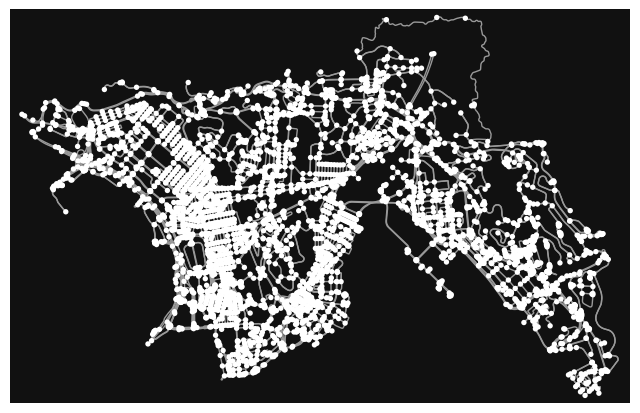

In [ ]:
fig, ax = ox.plot_graph(kln_drivemap)

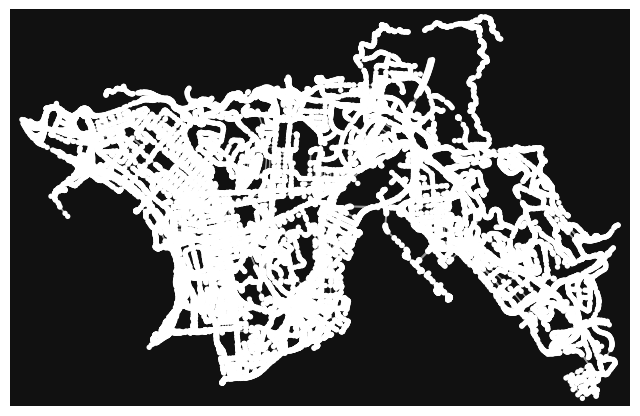

In [ ]:
fig, ax = ox.plot_graph(kln_drivemap_2)

In [ ]:
###  get all routes
travel_dist_opt_length = list()
travel_dist_opt_time = list()

for x in range(day_ops.shape[0]):

    pf1 = day_ops['trip_start_loc_longitude'][x]
    pf2 = day_ops['trip_start_loc_latitude'][x]
    pb1 = day_ops['trip_end_loc_longitude'][x]
    pb2 = day_ops['trip_end_loc_latitude'][x]

    orig_node, orig_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, pf1, pf2, return_dist=True)
    dest_node, dest_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, pb1, pb2, return_dist=True)
    
    ## optimized by path length
    route1 = ox.distance.shortest_path(kln_drivemap, orig_node, dest_node, weight='length')
    ## optimized by travelling time
    route2 = ox.distance.shortest_path(kln_drivemap, orig_node, dest_node, weight="travel_time")

    try:
        route_lengths_1 = ox.utils_graph.route_to_gdf(kln_drivemap, route1)["length"]
        travel_dist_opt_length.append(route_lengths_1)
    except:
        travel_dist_opt_length.append(np.nan)

    try:
        route_lengths_2 = ox.utils_graph.route_to_gdf(kln_drivemap, route2)["length"]
        travel_dist_opt_time.append(route_lengths_2)
    except:
        travel_dist_opt_time.append(np.nan)

In [ ]:
##  integrate to the dataframe
day_ops['trip_travel_distance_min_length'] = pd.Series(travel_dist_opt_length)
day_ops['trip_travel_distance_min_time'] = pd.Series(travel_dist_opt_time)
##  calculate route distance sum
day_ops['trip_travel_distance_min_length'] = day_ops['trip_travel_distance_min_length'].apply(lambda x: np.sum(x))
day_ops['trip_travel_distance_min_time'] = day_ops['trip_travel_distance_min_time'].apply(lambda x: np.sum(x))

###  2)  Geospatial Data Visualization & Spatial Clustering：

In [ ]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
from shapely.geometry import shape, Point, Polygon, MultiPolygon
from shapely.wkt import loads

In [ ]:
## geoJson
with open(f"/content/drive/MyDrive/Colab Notebooks/public healthcare research/accessible transport/TPU.json", "r") as j:
    geoj = json.load(j)
## geopandas dataframe
polys = gpd.GeoDataFrame.from_features(geoj["features"])

In [ ]:
##  extract the geoms from the mix of polygons and multipolygons of the areal units
geom = polys.pop('geometry')
##  extract the individual polygons from multipolygons
def polys_critic(i):
    if i.type == "MultiPolygon":
        l = [Polygon(x.exterior.coords) for x in i.geoms]
    else:
        l = [Polygon(i.exterior.coords)]
    return l
##  expand the individual polygons into rows
geom = geom.apply(lambda i: polys_critic(i)).explode()
##  re-merge to the original geodataframe
polys = polys.join(geom, how='inner')
##  reset Object ID
polys = polys.reset_index(drop=True)
polys['OBJECTID'] = pd.Series([x for x in range(1, polys.shape[0] + 1)])

In [ ]:
##  convert HK 1980 coordinates (EPSG 2326) to WGS84 (EPSG 4326)
from pyproj.transformer import TransformerGroup
from shapely.ops import transform
from pyproj import Transformer, Proj

tg = Transformer.from_proj(
    Proj(init='epsg:2326'),     # source coordinate system
    Proj(init='epsg:4326'))     # destination coordinate system

g2 = [transform(tg.transform, x) for x in polys['geometry']]

In [ ]:
###  migration
polys2 = copy.deepcopy(polys)
polys2['geometry'] = pd.Series(g2)

In [ ]:
day_ops_start_loc = day_ops.iloc[:,np.r_[0:5,10:12]]
day_ops_end_loc = day_ops.iloc[:,np.r_[5:10,10:12]]

day_ops_start_loc = day_ops_start_loc.groupby(
    ['trip_start_loc_latitude','trip_start_loc_longitude','trip_start_loc_chi_desc','trip_start_loc_eng_desc']).agg(
    {'trip_start_loc_stop_id': ['count'], 
     'trip_travel_distance_min_length': ['mean'], 
     'trip_travel_distance_min_time': ['mean']}).reset_index()
day_ops_start_loc.columns = [
    'trip_start_loc_latitude','trip_start_loc_longitude','trip_start_loc_chi_desc','trip_start_loc_eng_desc', 
    'passenger_count', 'trip_travel_distance_min_length', 'trip_travel_distance_min_time'
    ]
day_ops_end_loc = day_ops_end_loc.groupby(
    ['trip_end_loc_latitude','trip_end_loc_longitude','trip_end_loc_chi_desc','trip_end_loc_eng_desc']).agg(
    {'trip_end_loc_stop_id': ['count'], 
     'trip_travel_distance_min_length': ['mean'], 
     'trip_travel_distance_min_time': ['mean']}).reset_index()
day_ops_end_loc.columns = [
    'trip_end_loc_latitude','trip_end_loc_longitude','trip_end_loc_chi_desc','trip_end_loc_eng_desc', 
    'passenger_count', 'trip_travel_distance_min_length', 'trip_travel_distance_min_time'
    ]

In [ ]:
##  define map dataframes
startloc_map = gpd.GeoDataFrame(
    {
        "geometry": [Point(y, x) 
                     for x, y in zip(day_ops_start_loc['trip_start_loc_latitude'], 
                                     day_ops_start_loc['trip_start_loc_longitude'])],
        "passenger_count": day_ops_start_loc["passenger_count"],
        "location_tag": day_ops_start_loc["trip_start_loc_chi_desc"],
        "average_travel_distance_optimum_length": day_ops_start_loc['trip_travel_distance_min_length'],
        "average_travel_distance_optimum_time": day_ops_start_loc['trip_travel_distance_min_time'],
    })
endloc_map = gpd.GeoDataFrame(
    {
        "geometry": [Point(y, x) 
                     for x, y in zip(day_ops_end_loc['trip_end_loc_latitude'], 
                                     day_ops_end_loc['trip_end_loc_longitude'])],
        "passenger_count": day_ops_end_loc["passenger_count"],
        "location_tag": day_ops_end_loc["trip_end_loc_chi_desc"],
        "average_travel_distance_optimum_length": day_ops_end_loc['trip_travel_distance_min_length'],
        "average_travel_distance_optimum_time": day_ops_end_loc['trip_travel_distance_min_time'],
    })

In [ ]:
##  attribute points to polygons
start_assign = list()
for p in range(startloc_map.shape[0]):
    point = startloc_map['geometry'].iloc[p]
    for ply in range(polys2.shape[0]):
        polygon = polys2['geometry'].iloc[ply]
        if polygon.contains(point):
            start_assign.append(polygon)

##  attribute points to polygons
end_assign = list()
for p in range(endloc_map.shape[0]):
    point = endloc_map['geometry'].iloc[p]
    for ply in range(polys2.shape[0]):
        polygon = polys2['geometry'].iloc[ply]
        if polygon.contains(point):
            end_assign.append(polygon)

In [ ]:
startloc_choromap = gpd.GeoDataFrame(
    {
        "geometry" : start_assign,
        "passenger_count": startloc_map["passenger_count"],
        "average_travel_distance_optimum_length": startloc_map['average_travel_distance_optimum_length'],
        "average_travel_distance_optimum_time": startloc_map['average_travel_distance_optimum_time'],
    })
endloc_choromap = gpd.GeoDataFrame(
    {
        "geometry" : end_assign,
        "passenger_count": endloc_map["passenger_count"],
        "average_travel_distance_optimum_length": endloc_map['average_travel_distance_optimum_length'],
        "average_travel_distance_optimum_time": endloc_map['average_travel_distance_optimum_time'],
    })

<Axes: >

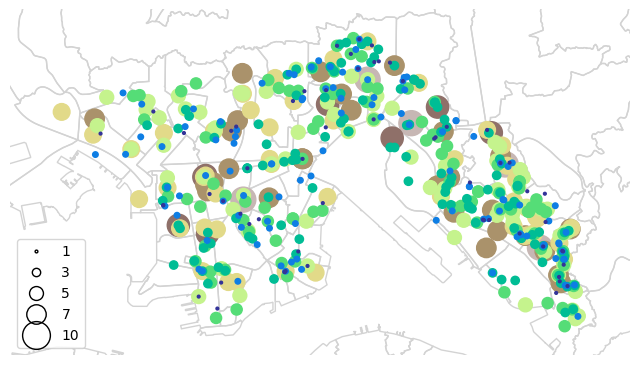

In [ ]:
##   Distribution of residential locations  (Origin of trips) by Passenger Count
gplt.pointplot(
    startloc_map,
    hue = "passenger_count",
    cmap='terrain',
    scale = "passenger_count",
    limits=(2, 20),
    legend=True,
    legend_var='scale',
    ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
)

<Axes: >

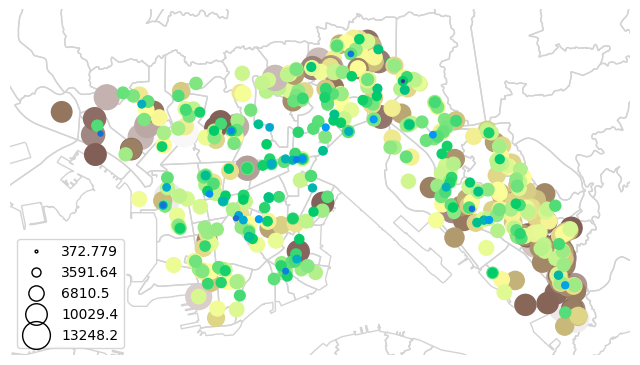

In [ ]:
##   Distribution of residential locations  (Origin of trips) by Travel Distance optimizing Travelling Time
gplt.pointplot(
    startloc_map,
    hue = "average_travel_distance_optimum_time",
    cmap='terrain',
    scale = "average_travel_distance_optimum_time",
    limits=(2, 20),
    legend=True,
    legend_var='scale',
    ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
)

In [ ]:
##  get chloropleth map data frame
##  aggregate data with respect to a spatial polygon
g_start = startloc_choromap.groupby(startloc_choromap['geometry'].to_wkt()).agg(
    {'passenger_count': ['sum'], "average_travel_distance_optimum_time": ['mean']}
).reset_index()
g_start.columns = ['geometry','passenger_count',"average_travel_distance_optimum_time"]
g_start = gpd.GeoDataFrame(g_start)
g_start.geometry = g_start['geometry'].apply(loads)

<Axes: >

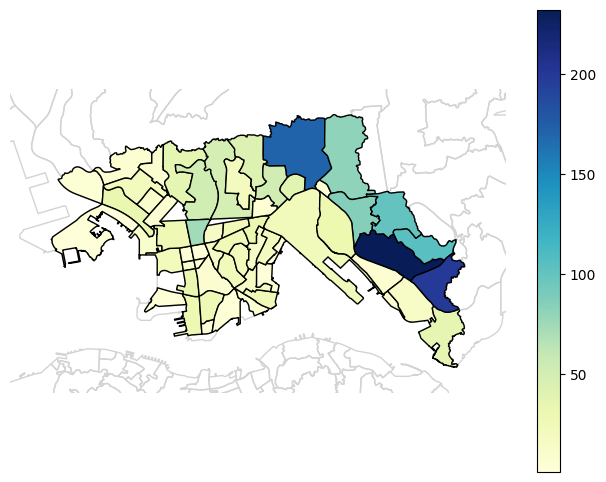

In [ ]:
##  chloropleth map by Passenger Count
gplt.choropleth(g_start,
                hue = "passenger_count",
                cmap='YlGnBu',
                legend=True,
                ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
                )

<Axes: >

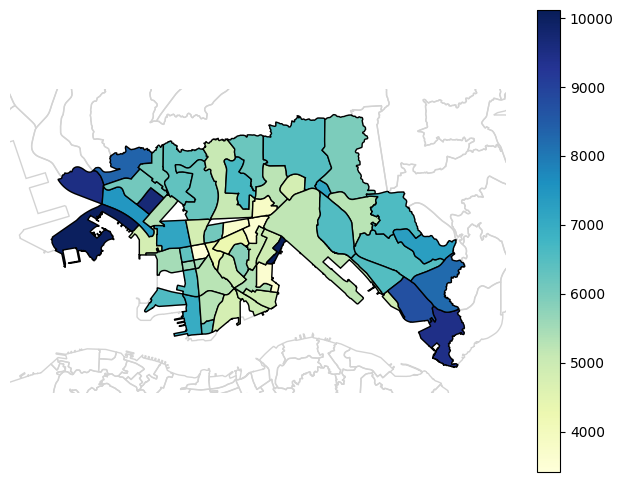

In [ ]:
##  chloropleth map by Average Travel Distance optimizing Travelling Time
gplt.choropleth(g_start,
                hue = "average_travel_distance_optimum_time",
                cmap='YlGnBu',
                legend=True,
                ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
                )

<Axes: >

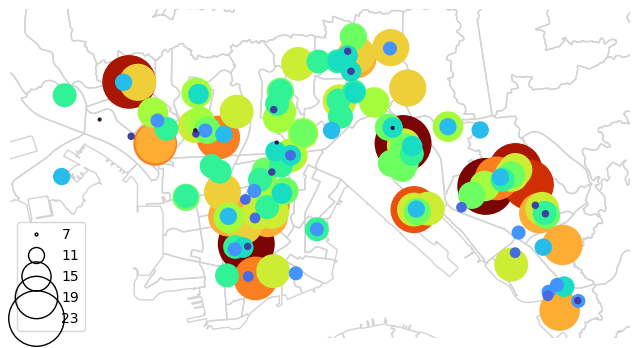

In [ ]:
##   Distribution of education/healthcare/community/government POI locations  (Destination of trips) by Passenger Count
gplt.pointplot(
    endloc_map,
    hue = "passenger_count",
    cmap='turbo',
    scale = "passenger_count",
    limits=(2, 40),
    legend=True,
    legend_var='scale',
    ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
)

<Axes: >

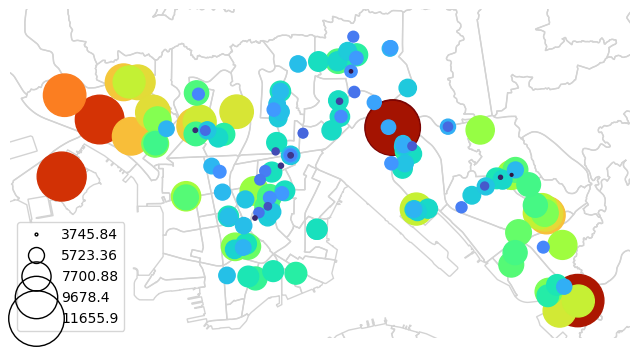

In [ ]:
##   Distribution of education/healthcare/community/government POI locations  (Destination of trips) 
##    by Travel Distance optimizing Travelling Time
gplt.pointplot(
    endloc_map,
    hue = "average_travel_distance_optimum_time",
    cmap='turbo',
    scale = "average_travel_distance_optimum_time",
    limits=(2, 40),
    legend=True,
    legend_var='scale',
    ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
)

In [ ]:
##  get chloropleth map data frame
##  aggregate data with respect to a spatial polygon
g_end = endloc_choromap.groupby(endloc_choromap['geometry'].to_wkt()).agg(
    {'passenger_count': ['sum'], "average_travel_distance_optimum_time": ['mean']}
).reset_index()
g_end.columns = ['geometry','passenger_count', "average_travel_distance_optimum_time"]
g_end = gpd.GeoDataFrame(g_end)
g_end.geometry = g_end['geometry'].apply(loads)

<Axes: >

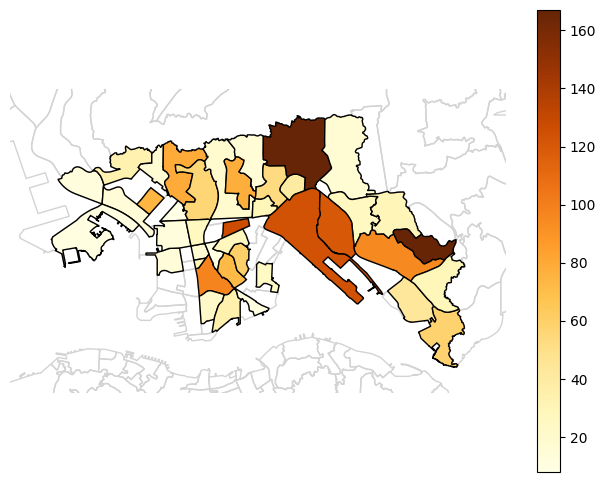

In [ ]:
##  chloropleth map by Passenger Count
gplt.choropleth(g_end,
                hue = "passenger_count",
                cmap='YlOrBr',
                legend=True,
                ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
                )

<Axes: >

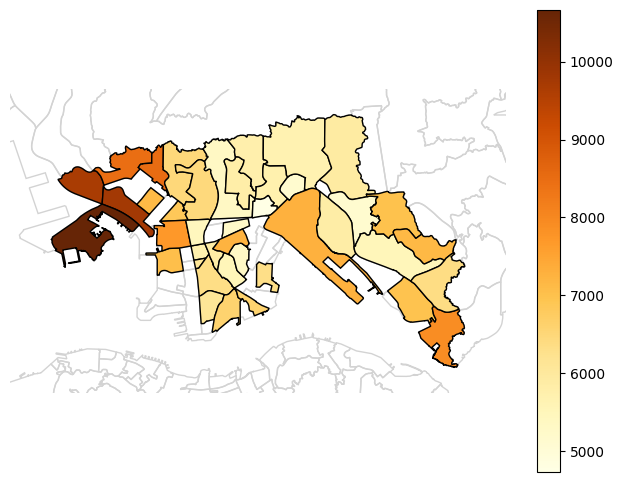

In [ ]:
##  chloropleth map by Average Travel Distance optimizing Travelling Time
gplt.choropleth(g_end,
                hue = "average_travel_distance_optimum_time",
                cmap='YlOrBr',
                legend=True,
                ax = gplt.polyplot(gpd.GeoDataFrame(polys2),
                       edgecolor='lightgray')
                )

In [ ]:
###  Spatial Clustering or Spatial Autocorrelation or Point Pattern Testing
import seaborn
import contextily
import pysal
from pysal.lib import weights
from pysal.explore import esda
from esda.moran import Moran
from splot import esda as esdaplot
from pointpats import centrography
from matplotlib import pyplot as plt

In [ ]:
##  nearest neighbours
gstartw = weights.distance.KNN.from_dataframe(g_start, k=4)
##  rowise standardization (per location)
gstartw.transform = "R"

##  weighted attribute
g_start["w_passenger_count"] = weights.lag_spatial(gstartw, g_start["passenger_count"])
##  central tendency
g_start["passenger_count_std"] = g_start["passenger_count"] - g_start["passenger_count"].mean()
g_start["w_passenger_count_std"] = weights.lag_spatial(gstartw, g_start["passenger_count"])

##  weighted attribute
g_start["w_average_travel_distance_optimum_time"] = weights.lag_spatial(gstartw, g_start["average_travel_distance_optimum_time"])
##  central tendency
g_start["average_travel_distance_optimum_time_std"] = g_start["average_travel_distance_optimum_time"] - g_start["average_travel_distance_optimum_time"].mean()
g_start["w_average_travel_distance_optimum_time_std"] = weights.lag_spatial(gstartw, g_start["average_travel_distance_optimum_time"])

In [ ]:
##  nearest neighbours
gendw = weights.distance.KNN.from_dataframe(g_end, k=4)
##  rowise standardization (per location)
gendw.transform = "R"

##  weighted attribute
g_end["w_passenger_count"] = weights.lag_spatial(gendw, g_end["passenger_count"])
##  central tendency
g_end["passenger_count_std"] = g_end["passenger_count"] - g_end["passenger_count"].mean()
g_end["w_passenger_count_std"] = weights.lag_spatial(gendw, g_end["passenger_count"])

##  weighted attribute
g_end["w_average_travel_distance_optimum_time"] = weights.lag_spatial(gendw, g_end["average_travel_distance_optimum_time"])
##  central tendency
g_end["average_travel_distance_optimum_time_std"] = g_end["average_travel_distance_optimum_time"] - g_end["average_travel_distance_optimum_time"].mean()
g_end["w_average_travel_distance_optimum_time_std"] = weights.lag_spatial(gendw, g_end["average_travel_distance_optimum_time"])

In [ ]:
##  local indicators of spatial autocorrelation
start_lisa = esda.moran.Moran_Local(g_start["passenger_count_std"], gstartw)
end_lisa = esda.moran.Moran_Local(g_end["passenger_count_std"], gendw)

In [ ]:
##  percentages of area units considered to be significant autocorrelation locally
print("Starting (Home Locations)：" + str(round((start_lisa.p_sim < 0.05).sum() * 100 / len(start_lisa.p_sim), 2)) + " %")
print("Ending (Destinations)：" + str(round((end_lisa.p_sim < 0.05).sum() * 100 / len(end_lisa.p_sim), 2)) + " %")

Starting (Home Locations)：13.56 %
Ending (Destinations)：19.51 %


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

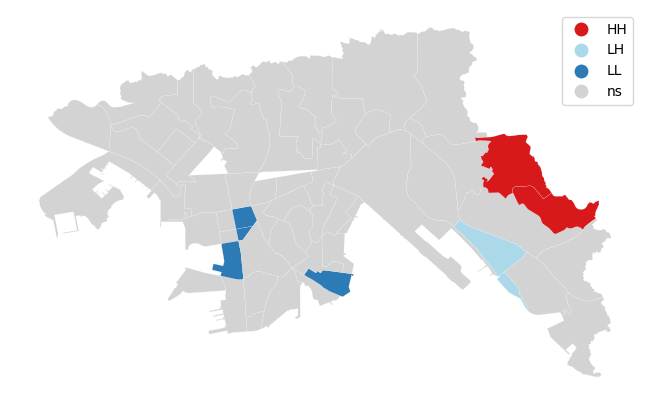

In [ ]:
##  Start (Origin) location spatial autocorrelations by Passenger Count
esdaplot.lisa_cluster(start_lisa, g_start, p=0.05,
                      figsize=(10, 5))

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

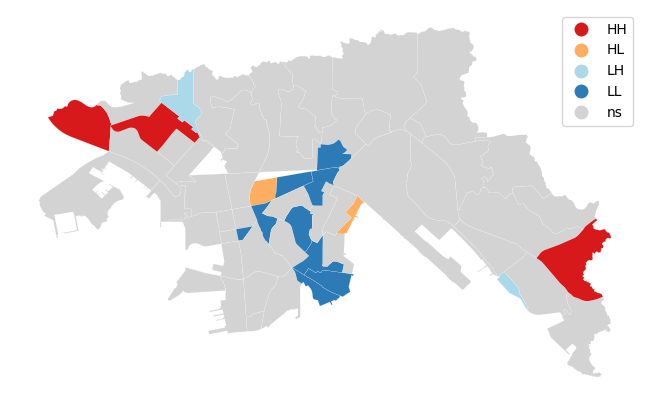

In [ ]:
##  Start (Origin) location spatial autocorrelations by Average Travel Distance optimizing Travelling Time
esdaplot.lisa_cluster(start_lisa, g_start, p=0.05,
                      figsize=(10, 5))

In [ ]:
##  local indicators of spatial autocorrelation
start_lisa = esda.moran.Moran_Local(g_start["average_travel_distance_optimum_time_std"], gstartw)
end_lisa = esda.moran.Moran_Local(g_end["average_travel_distance_optimum_time_std"], gendw)

In [ ]:
##  percentages of area units considered to be significant autocorrelation locally
print("Starting (Home Locations)：" + str(round((start_lisa.p_sim < 0.05).sum() * 100 / len(start_lisa.p_sim), 2)) + " %")
print("Ending (Destinations)：" + str(round((end_lisa.p_sim < 0.05).sum() * 100 / len(end_lisa.p_sim), 2)) + " %")

Starting (Home Locations)：27.12 %
Ending (Destinations)：34.15 %


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

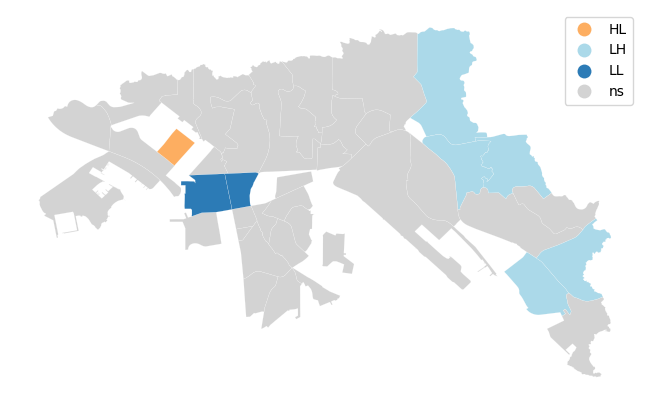

In [ ]:
##  End (Destination) location spatial autocorrelations by Passenger Count
esdaplot.lisa_cluster(end_lisa, g_end, p=0.05,
                      figsize=(10, 5))

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

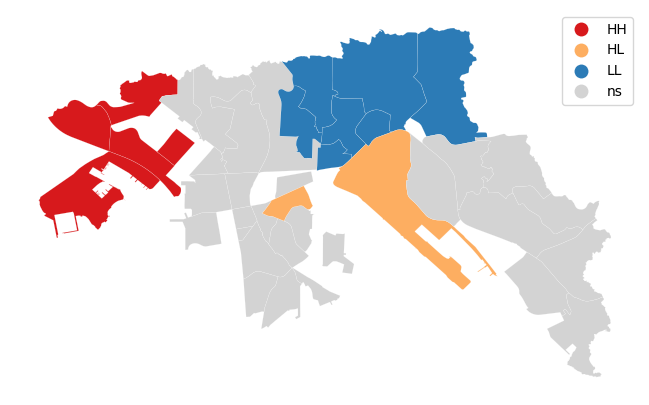

In [ ]:
##  End (Destination) location spatial autocorrelations by Average Travel Distance optimizing Travelling Time
esdaplot.lisa_cluster(end_lisa, g_end, p=0.05,
                      figsize=(10, 5))

###  3)  ORTools： Vehicle Routing Problem with Pick-up & Delivery  (VRP w PD)：

I tried filtering locations only from the first 20 trips (1% of the simulated data size) and then first 50 trips (2.5% of the simulated data size), the actual number of trips included for the 20-location data is 39; while this number for the 50-location data is 113. <br>

Since the ORTools required a distance matrix with separate entries of different indices even for the same location, the dimension of the distance matrix for the 20-location data is 78 x 78, and that for the 50-location data is 226 x 226. <br>

That means the complexity and execution grow exponentially with number of trips even having repeated locations. <br>

The 20-location (39-trip) solution takes around 30 minutes; while the 50-location (113-trip) solution takes 23 hours to complete. <br>

Practically speaking, to run solutions in ORTools package, it is only workable given a cluster of computing resources, unless for small scaled problems. In the next session, I tried to implement a reinforcement learning (RL) agent in GYM environment, adopting an actor-critic structure to achieve generating feasible solutions for more locations from the 200 trips (10% of the simulated data size).

In [7]:
##  Reference:  https://developers.google.com/optimization/routing/cvrp
##  Reference:  https://developers.google.com/optimization/routing/pickup_delivery

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [9]:
####  re-indexing for available points
day_ops['origin_point_map_idx'] = pd.Series([x[0] for x in simulated_trips])
day_ops['destination_point_map_idx'] = pd.Series([x[1] for x in simulated_trips])
day_ops['origin_point_reset_idx'] = day_ops["origin_point_map_idx"].factorize()[0] + 1
day_ops['destination_point_reset_idx'] = day_ops["destination_point_map_idx"].factorize()[0] + 1

In [10]:
##  subset first 20 trips out of 2000 trips (1%; for testing OR Tools)

simulated_trips_subset = simulated_trips[0:20]
day_ops_subset = day_ops.iloc[0:20,:]
day_ops = day_ops[(day_ops['origin_point_reset_idx'].isin(day_ops_subset['origin_point_reset_idx'])) &
                  (day_ops['destination_point_reset_idx'].isin(day_ops_subset['destination_point_reset_idx']))]
simulated_trips = [simulated_trips[i] for i in list(day_ops.index)]

##  subset first 50 trips out of 2000 trips (2.5%; for testing OR Tools)

simulated_trips_subset = simulated_trips[0:50]
day_ops_subset = day_ops.iloc[0:50,:]
day_ops = day_ops[(day_ops['origin_point_reset_idx'].isin(day_ops_subset['origin_point_reset_idx'])) &
                  (day_ops['destination_point_reset_idx'].isin(day_ops_subset['destination_point_reset_idx']))]
simulated_trips = [simulated_trips[i] for i in list(day_ops.index)]

In [14]:
###  distance matrix
def generate_dist(value_col, operations_df, shortest_path_weight):

    dist = operations_df.pivot_table(index=['trip_start_loc_latitude','trip_start_loc_longitude'],
                                     columns=['trip_end_loc_latitude','trip_end_loc_longitude'],
                                     values = value_col,
                                     aggfunc = 'mean')

    for s in range(dist.shape[0]):
        for e in range(dist.shape[1]):
            if pd.isnull(dist.iloc[s,e]):
                s1, s2 = dist.index[s][0], dist.index[s][1]
                e1, e2 = dist.columns[e][0], dist.columns[e][1]
                orig_node, orig_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, s2, s1, return_dist=True)
                dest_node, dest_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, e2, e1, return_dist=True)
                route = ox.distance.shortest_path(kln_drivemap, orig_node, dest_node, weight = shortest_path_weight)
                try:
                    dist.iloc[s,e] = np.sum(ox.utils_graph.route_to_gdf(kln_drivemap, route)["length"]\
                                            .apply(lambda x: np.sum(x)))
                except:
                    dist.iloc[s,e] = np.nan

    return dist

dist1 = generate_dist('trip_travel_distance_min_length', day_ops, 'length')
dist2 = generate_dist('trip_travel_distance_min_time', day_ops, 'travel_time')

In [15]:
##  <-- 20 starting locations; 19 ending locations
print(dist1.shape)
print(dist2.shape)

(20, 19)
(20, 19)


In [17]:
##  mapping to the distance matrix row and column the reset indices
dist1_ridx = list()
dist1_cidx = list()
for i in list(dist1.index):
    idx = day_ops[
                (day_ops['trip_start_loc_latitude'] == i[0]) & 
                (day_ops['trip_start_loc_longitude'] == i[1])
            ]['origin_point_reset_idx']
    dist1_ridx.append(list(set(idx))[0])
for j in list(dist1.columns):
    idx = day_ops[
                (day_ops['trip_end_loc_latitude'] == j[0]) & 
                (day_ops['trip_end_loc_longitude'] == j[1])
            ]['destination_point_reset_idx']
    dist1_cidx.append(list(set(idx))[0])

In [18]:
##  rearrange the re-indexed point indices
ns = pd.Series(dist1_ridx)
ns.index = dist1.index

dist1 = pd.concat([dist1, ns], axis=1)
dist1.columns = list(dist1.columns[0:dist1.shape[1]-1]) + ['ridx']
dist1 = dist1.sort_values(by=['ridx'])
dist1 = dist1.drop(['ridx'], axis=1)

dist2 = pd.concat([dist2, ns], axis=1)
dist2.columns = list(dist2.columns[0:dist2.shape[1]-1]) + ['ridx']
dist2 = dist2.sort_values(by=['ridx'])
dist2 = dist2.drop(['ridx'], axis=1)

ne = pd.Series(dist1_cidx)
ne.index = dist1.columns

dist1 = pd.concat([dist1, pd.DataFrame(ne).T], axis=0)
dist1.index = list(dist1.index[0:dist1.shape[0]-1]) + ['cidx']
dist1.columns = pd.MultiIndex.from_arrays([dist1.columns, dist1.loc['cidx'].apply(lambda x: int(x))])
dist1 = dist1.iloc[0:dist1.shape[0]-1]
dist1 = dist1.sort_index(axis=1, level=1)

dist2 = pd.concat([dist2, pd.DataFrame(ne).T], axis=0)
dist2.index = list(dist2.index[0:dist2.shape[0]-1]) + ['cidx']
dist2.columns = pd.MultiIndex.from_arrays([dist2.columns, dist2.loc['cidx'].apply(lambda x: int(x))])
dist2 = dist2.iloc[0:dist2.shape[0]-1]
dist2 = dist2.sort_index(axis=1, level=1)

In [19]:
dist1

,"(22.33706418651036, 114.2010688251827)","(22.31667282283165, 114.1801840311821)","(22.32474091225462, 114.1828831426639)","(22.34509940224272, 114.1939866542816)","(22.30336168469844, 114.172371300609)","(22.31305737903815, 114.1756148636341)","(22.33678722335734, 114.1821360263832)","(22.3316363310415, 114.168526503638)","(22.3145474360751, 114.1778222904717)","(22.33923812463105, 114.1827771938966)","(22.34634601165846, 114.1976297173105)","(22.31702628007083, 114.2324522137642)","(22.33433381121663, 114.1945884749293)","(22.29838066316956, 114.2408273633205)","(22.33023363248484, 114.1706568002701)","(22.32752422333976, 114.1818449646235)","(22.31817193413518, 114.175942595698)","(22.30886777960383, 114.233997836709)","(22.30277475243811, 114.1779224761725)"
cidx,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
"(22.30275604567581, 114.2413240670067)",6601.405,8725.957,7990.473,7729.541,9479.304,9558.945,9043.493,10415.374,9230.815,8710.242,7681.643,3863.222,7629.406,383.900,10245.451,8406.923,9050.122,1519.183,9395.738
"(22.32248845511457, 114.1709924153514)",4204.443,1699.514,1746.818,4595.632,2353.351,1395.227,2613.046,1461.893,2004.195,2954.996,5175.812,8658.077,4073.797,10178.691,1291.970,1623.070,1203.718,9791.925,3400.907
"(22.33153122524506, 114.2142614722252)",1976.167,5153.220,4004.099,3104.303,6965.004,5783.148,4418.255,6146.615,5452.042,4085.004,3056.405,4256.348,3004.168,5582.635,5976.692,4138.164,5063.748,5195.869,6890.609
"(22.34329096233077, 114.2086742337068)",1195.410,5219.524,4070.403,1705.397,7031.308,5849.452,3678.159,6010.090,5518.346,3344.908,1287.625,5064.417,2223.411,6973.067,5840.167,4319.307,5130.052,6586.301,6956.913
"(22.31930524894038, 114.2275671443912)",4595.504,6889.402,6067.822,5723.640,7930.649,7846.871,7037.592,8492.723,7515.112,6704.341,5675.742,1835.916,5623.505,3018.278,8322.800,6484.272,7127.471,2631.512,7847.083
"(22.32767255426425, 114.2094750814113)",2778.606,3833.251,3011.671,3906.742,5221.763,4790.067,4557.166,5436.572,4459.614,4643.308,3858.844,4024.620,3641.285,5350.859,5266.649,3428.121,4071.320,4964.093,5138.197
"(22.31274596627436, 114.1698427498341)",4472.609,1399.727,1959.142,5247.465,1180.123,1054.490,3264.879,2709.952,1744.645,3606.829,5470.908,8926.243,4341.963,10167.229,2603.792,2242.565,903.931,9780.463,2227.679
"(22.30332559678425, 114.1738852595805)",5584.127,2455.808,3188.592,6476.915,171.754,1530.516,4494.329,3941.800,2800.726,4836.279,6641.130,9084.465,5553.639,9791.402,3835.640,3472.015,2133.381,9404.636,886.778
"(22.31781969071164, 114.1809605273558)",4102.490,414.849,1786.981,5159.764,2821.466,1639.610,3177.178,3208.662,946.793,3519.128,5159.493,8160.698,4072.002,9266.707,3038.739,2154.864,920.210,8879.941,2948.068


In [20]:
dist2

,"(22.33706418651036, 114.2010688251827)","(22.31667282283165, 114.1801840311821)","(22.32474091225462, 114.1828831426639)","(22.34509940224272, 114.1939866542816)","(22.30336168469844, 114.172371300609)","(22.31305737903815, 114.1756148636341)","(22.33678722335734, 114.1821360263832)","(22.3316363310415, 114.168526503638)","(22.3145474360751, 114.1778222904717)","(22.33923812463105, 114.1827771938966)","(22.34634601165846, 114.1976297173105)","(22.31702628007083, 114.2324522137642)","(22.33433381121663, 114.1945884749293)","(22.29838066316956, 114.2408273633205)","(22.33023363248484, 114.1706568002701)","(22.32752422333976, 114.1818449646235)","(22.31817193413518, 114.175942595698)","(22.30886777960383, 114.233997836709)","(22.30277475243811, 114.1779224761725)"
cidx,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
"(22.30275604567581, 114.2413240670067)",8530.292,10591.527,9096.141,12721.623,9885.688,10875.190,10394.119,11280.819,10067.770,11598.692,10138.255,3892.507,9854.636,383.900,11069.566,9231.038,10155.790,2824.657,9802.122
"(22.32248845511457, 114.1709924153514)",4261.200,3112.319,1747.733,5141.973,2353.351,2092.595,2814.469,1503.223,2747.065,4019.042,5299.257,11743.958,4298.618,13188.614,1291.970,1651.388,1325.419,10762.121,4629.679
"(22.33153122524506, 114.2142614722252)",2682.883,5499.485,4004.099,5880.045,7712.195,5783.148,5302.077,6188.777,5746.015,5526.064,3763.121,4482.368,3752.647,9653.480,5977.524,4138.996,5063.748,7226.987,7628.629
"(22.34329096233077, 114.2086742337068)",1195.410,5853.671,4518.639,2447.750,9392.130,6297.688,4404.478,8012.678,9574.212,4071.227,1287.625,5192.336,2455.929,10634.398,7450.288,5901.552,5578.288,8207.905,9308.564
"(22.31930524894038, 114.2275671443912)",4835.227,8118.822,6623.436,8032.389,8050.238,8402.485,7921.414,8808.114,8232.320,9125.987,5915.465,1888.596,5665.268,4280.518,8596.861,6758.333,7683.085,2996.404,7966.672
"(22.32767255426425, 114.2094750814113)",2778.606,5401.249,4500.112,5975.768,5738.671,5818.312,5798.090,8919.418,5920.753,5594.940,3858.844,7128.166,3848.370,8572.822,8357.028,4635.009,5559.761,6146.329,5655.105
"(22.31274596627436, 114.1698427498341)",6876.759,2168.848,2266.559,5898.477,1180.123,1054.490,4276.688,2886.063,2513.766,4618.638,5818.083,11822.898,4817.444,13267.554,2674.810,3248.258,903.931,10841.061,3827.205
"(22.30332559678425, 114.1738852595805)",5835.678,2502.183,3278.477,7072.178,171.754,1615.304,4610.023,4822.427,2847.101,4951.973,6892.681,10781.817,6254.915,12226.473,4611.174,3581.593,2536.833,9799.980,886.778
"(22.31781969071164, 114.1809605273558)",4710.792,414.849,2395.283,6027.201,3031.634,1639.610,3183.294,3395.698,946.793,4904.270,5767.795,12193.550,5130.029,13638.206,3184.445,3263.664,920.210,11211.713,2948.068


In [21]:
##  fill NAs in the distance matrix

def refill_na_with_complex_network(complex_network, dist_matrix, shortest_path_weight):
    for s in range(dist_matrix.shape[0]):
        for e in range(dist_matrix.shape[1]):
            if pd.isnull(dist_matrix.iloc[s,e]):
                s1, s2 = dist_matrix.index[s][0], dist_matrix.index[s][1]
                e1, e2 = dist_matrix.columns[e][0], dist_matrix.columns[e][1]
                orig_node, orig_node_dist_from_point = ox.distance.nearest_nodes(complex_network, s2, s1, return_dist=True)
                dest_node, dest_node_dist_from_point = ox.distance.nearest_nodes(complex_network, e2, e1, return_dist=True)
                route = ox.distance.shortest_path(complex_network, orig_node, dest_node, weight = shortest_path_weight)
                try:
                    dist_matrix.iloc[s,e] = np.sum(ox.utils_graph.route_to_gdf(complex_network, route)["length"]\
                                                   .apply(lambda x: np.sum(x)))
                except:
                    dist_matrix.iloc[s,e] = np.sum(orig_node_dist_from_point) + np.sum(dest_node_dist_from_point)
    return dist_matrix

dist1_re = copy.deepcopy(dist1)
dist1_re = dist1_re.droplevel(1, axis = 1)
dist1_re = refill_na_with_complex_network(kln_drivemap_2, dist1_re, 'length')
dist2_re = copy.deepcopy(dist2)
dist2_re = dist2_re.droplevel(1, axis = 1)
dist2_re = refill_na_with_complex_network(kln_drivemap_2, dist2_re, 'travel_time')

In [24]:
###  Distance Matrix (filling the missing blocks):
###    start location to start location
###    end location to end lcoation

sd_list = list()
ed_list = list()

for n in range(dist1_re.shape[0]):

    sd_sublist = list()

    for m in range(n+1, dist1_re.shape[0]):
        s1, s2 = dist1_re.index[n][0], dist1_re.index[n][1]
        e1, e2 = dist1_re.index[m][0], dist1_re.index[m][1]

        orig_node, orig_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, s2, s1, return_dist=True)
        dest_node, dest_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, e2, e1, return_dist=True)
        route = ox.distance.shortest_path(kln_drivemap, orig_node, dest_node, weight = "length")

        try:
            d = np.sum(ox.utils_graph.route_to_gdf(kln_drivemap, route)["length"].apply(lambda x: np.sum(x)))
        except:
            d = np.sum(orig_node_dist_from_point) + np.sum(dest_node_dist_from_point)

        sd_sublist.append(d)

    sd_list.append(sd_sublist)

for n in range(dist1_re.shape[1]):

    ed_sublist = list()

    for m in range(n+1, dist1_re.shape[1]):
        s1, s2 = dist1_re.columns[n][0], dist1_re.columns[n][1]
        e1, e2 = dist1_re.columns[m][0], dist1_re.columns[m][1]

        orig_node, orig_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, s2, s1, return_dist=True)
        dest_node, dest_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, e2, e1, return_dist=True)
        route = ox.distance.shortest_path(kln_drivemap, orig_node, dest_node, weight = "length")

        try:
            d = np.sum(ox.utils_graph.route_to_gdf(kln_drivemap, route)["length"].apply(lambda x: np.sum(x)))
        except:
            d = np.sum(orig_node_dist_from_point) + np.sum(dest_node_dist_from_point)

        ed_sublist.append(d)

    ed_list.append(ed_sublist)
    
sd_list_2 = list()
ed_list_2 = list()

for n in range(dist2_re.shape[0]):

    sd_sublist_2 = list()

    for m in range(n+1, dist2_re.shape[0]):
        s1, s2 = dist2_re.index[n][0], dist2_re.index[n][1]
        e1, e2 = dist2_re.index[m][0], dist2_re.index[m][1]

        orig_node, orig_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, s2, s1, return_dist=True)
        dest_node, dest_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, e2, e1, return_dist=True)
        route = ox.distance.shortest_path(kln_drivemap, orig_node, dest_node, weight = "travel_time")

        try:
            d = np.sum(ox.utils_graph.route_to_gdf(kln_drivemap, route)["length"].apply(lambda x: np.sum(x)))
        except:
            d = np.sum(orig_node_dist_from_point) + np.sum(dest_node_dist_from_point)

        sd_sublist_2.append(d)

    sd_list_2.append(sd_sublist_2)

for n in range(dist2_re.shape[1]):

    ed_sublist_2 = list()

    for m in range(n+1, dist2_re.shape[1]):
        s1, s2 = dist2_re.columns[n][0], dist2_re.columns[n][1]
        e1, e2 = dist2_re.columns[m][0], dist2_re.columns[m][1]

        orig_node, orig_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, s2, s1, return_dist=True)
        dest_node, dest_node_dist_from_point = ox.distance.nearest_nodes(kln_drivemap, e2, e1, return_dist=True)
        route = ox.distance.shortest_path(kln_drivemap, orig_node, dest_node, weight = "travel_time")

        try:
            d = np.sum(ox.utils_graph.route_to_gdf(kln_drivemap, route)["length"].apply(lambda x: np.sum(x)))
        except:
            d = np.sum(orig_node_dist_from_point) + np.sum(dest_node_dist_from_point)

        ed_sublist_2.append(d)

    ed_list_2.append(ed_sublist_2)

In [28]:
##  distance matrix in list
dist1_re_list = dist1_re.values.tolist()
dist2_re_list = dist2_re.values.tolist()

In [30]:
##  combine into a full-squared distance matrix
sd_matrix_1 = np.zeros((len(dist1_re_list), len(dist1_re_list)))
ed_matrix_1 = np.zeros((len(dist1_re_list[0]), len(dist1_re_list[0])))
sd_matrix_2 = np.zeros((len(dist2_re_list), len(dist2_re_list)))
ed_matrix_2 = np.zeros((len(dist2_re_list[0]), len(dist2_re_list[0])))

for n in range(sd_matrix_1.shape[0]):
    for m in range(n+1, sd_matrix_1.shape[1]):
        sd_matrix_1[n, m] = sd_list[n][m-n-1]
        sd_matrix_1[m, n] = sd_list[n][m-n-1]

for n in range(sd_matrix_2.shape[0]):
    for m in range(n+1, sd_matrix_2.shape[1]):
        sd_matrix_2[n, m] = sd_list_2[n][m-n-1]
        sd_matrix_2[m, n] = sd_list_2[n][m-n-1]

for n in range(ed_matrix_1.shape[0]):
    for m in range(n+1, ed_matrix_1.shape[1]):
        ed_matrix_1[n, m] = ed_list[n][m-n-1]
        ed_matrix_1[m, n] = ed_list[n][m-n-1]

for n in range(ed_matrix_2.shape[0]):
    for m in range(n+1, ed_matrix_2.shape[1]):
        ed_matrix_2[n, m] = ed_list_2[n][m-n-1]
        ed_matrix_2[m, n] = ed_list_2[n][m-n-1]
        
dist_matrix_1 = np.zeros((len(dist1_re_list) + len(dist1_re_list[0]), len(dist1_re_list) + len(dist1_re_list[0])))
dist_matrix_2 = np.zeros((len(dist2_re_list) + len(dist2_re_list[0]), len(dist2_re_list) + len(dist2_re_list[0])))

dist_matrix_1[0:len(dist1_re_list), 0:len(dist1_re_list)] = sd_matrix_1
dist_matrix_1[len(dist1_re_list):, len(dist1_re_list):] = ed_matrix_1
dist_matrix_1[0:len(dist1_re_list), len(dist1_re_list):] = dist1_re.to_numpy()
dist_matrix_1[len(dist1_re_list):, 0:len(dist1_re_list)] = dist1_re.to_numpy().T

dist_matrix_2[0:len(dist2_re_list), 0:len(dist2_re_list)] = sd_matrix_2
dist_matrix_2[len(dist2_re_list):, len(dist2_re_list):] = ed_matrix_2
dist_matrix_2[0:len(dist2_re_list), len(dist2_re_list):] = dist2_re.to_numpy()
dist_matrix_2[len(dist2_re_list):, 0:len(dist2_re_list)] = dist2_re.to_numpy().T

In [32]:
##  <-- 20 starting locations + 19 ending locations
print(dist_matrix_1.shape)
print(dist_matrix_2.shape)

(39, 39)
(39, 39)


In [33]:
##  pickup & delivery location reindexing
simulated_trips_reindex = list()
for n in range(len(simulated_trips)):
    b_adjust = day_ops['origin_point_reset_idx'].max()
    a = simulated_trips[n][0]
    b = simulated_trips[n][1]
    ra = day_ops[day_ops['origin_point_map_idx'] == a]['origin_point_reset_idx'].max()
    rb = day_ops[day_ops['destination_point_map_idx'] == b]['destination_point_reset_idx'].max() + b_adjust
    simulated_trips_reindex.append([ra, rb])

In [50]:
###   preparation for ORTools
simulated_trips_reindex = [[simulated_trips_reindex[i][0] - 1, simulated_trips_reindex[i][1] - 1]
                           for i in range(len(simulated_trips_reindex))]

dist_matrix_1 = [[int(round(y, 0)) for y in x] for x in dist_matrix_1]
dist_matrix_2 = [[int(round(y, 0)) for y in x] for x in dist_matrix_2]

dist_matrix_1_or = np.zeros((len(simulated_trips_reindex) * 2, len(simulated_trips_reindex) * 2))
dist_matrix_2_or = np.zeros((len(simulated_trips_reindex) * 2, len(simulated_trips_reindex) * 2))

simulated_trips_flatten = [y for x in simulated_trips_reindex for y in x]
for n in range(len(simulated_trips_flatten)):
    for m in range(n+1, len(simulated_trips_flatten)):
        dist_matrix_1_or[n,m] = dist_matrix_1[simulated_trips_flatten[n]][simulated_trips_flatten[m]]
        dist_matrix_1_or[m,n] = dist_matrix_1_or[n,m]
        dist_matrix_2_or[n,m] = dist_matrix_2[simulated_trips_flatten[n]][simulated_trips_flatten[m]]
        dist_matrix_2_or[m,n] = dist_matrix_2_or[n,m]

###  ORTools required a distance matrix with separate entries of different indices even for the same location
simulated_trips_reindex_or = [[2 * n, 2 * n + 1] for n in range(len(simulated_trips_reindex))]

###  for ORTools setting, if location index 0 is regarded as a depot, it cannot have any route paired with another point
simulated_trips_reindex_or = simulated_trips_reindex_or[1:]

In [ ]:
def create_data_model(pick_drop_loc_list, dist_matrix, n_vehicles, n_depots = 0):
    data = {}
    data['pickups_deliveries'] = pick_drop_loc_list
    data['distance_matrix'] = dist_matrix
    data['num_vehicles'] = n_vehicles
    data['depot'] = n_depots
    return data


def gather_data(data, manager, routing, distance_dimension):

      for request in data['pickups_deliveries']:
            pickup_index = manager.NodeToIndex(request[0])
            delivery_index = manager.NodeToIndex(request[1])
            routing.AddPickupAndDelivery(pickup_index, delivery_index)
            routing.solver().Add(
              routing.VehicleVar(pickup_index) == routing.VehicleVar(delivery_index)
              )
            routing.solver().Add(
              distance_dimension.CumulVar(pickup_index) <= distance_dimension.CumulVar(delivery_index)
              )


def print_solution(data, manager, routing, solution):

    print(f'Objective: {solution.ObjectiveValue()}')

    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0

        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)

        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)

        total_distance += route_distance

    print('Total Travelling Distance of all routes: {}m'.format(total_distance))


def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]



In [ ]:
# Instantiate the data problem.
data = create_data_model(pick_drop_loc_list = simulated_trips_reindex_or,
                         dist_matrix = dist_matrix_1_or,
                         n_vehicles = 5)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'],
                                       data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

# Define cost of each arc
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


# Add Distance constraint.
dimension_name = 'Distance'
routing.AddDimension(
    transit_callback_index,
    0,                          # no slack
    100000,                     # vehicle maximum travel distance
    True,                       # start cumulative number to zero
    dimension_name)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)


# Define Transportation Requests.
gather_data(data, manager, routing, distance_dimension)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)

In [ ]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

In [9]:
# Print solution on console.  (20 trip-locations; total 39 trips)
if solution:
    print_solution(data, manager, routing, solution)

Objective: 3193858
Route for vehicle 0:
 0 ->  8 ->  30 ->  62 ->  54 ->  38 ->  9 ->  14 ->  46 ->  39 ->  63 ->  15 ->  31 ->  47 ->  55 -> 0
Distance of the route: 30715m

Route for vehicle 1:
 0 ->  58 ->  26 ->  4 ->  56 ->  1 ->  48 ->  42 ->  44 ->  6 ->  64 ->  18 ->  7 ->  57 ->  34 ->  27 ->  65 ->  49 ->  5 ->  19 ->  32 ->  50 ->  45 ->  43 ->  40 ->  28 ->  51 ->  35 ->  41 ->  33 ->  59 ->  29 -> 0
Distance of the route: 30624m

Route for vehicle 2:
 0 ->  24 ->  36 ->  60 ->  10 ->  61 ->  22 ->  11 ->  52 ->  53 ->  23 ->  25 ->  37 -> 0
Distance of the route: 30588m

Route for vehicle 3:
 0 ->  2 ->  20 ->  12 ->  16 ->  3 ->  13 ->  17 ->  21 -> 0
Distance of the route: 30431m

Route for vehicle 4:
 0 -> 0
Distance of the route: 0m

Total Travelling Distance of all routes: 122358m


In [11]:
# Print solution on console.  (50 trip-locations; total 113 trips)
if solution:
    print_solution(data, manager, routing, solution)

Objective: 4296447
Route for vehicle 0:
 0 ->  24 ->  148 ->  36 ->  174 ->  4 ->  66 ->  6 ->  175 ->  7 ->  208 ->  178 ->  5 ->  154 ->  20 ->  56 ->  57 ->  149 ->  62 ->  67 ->  92 ->  21 ->  155 ->  209 ->  63 ->  25 ->  93 ->  179 ->  194 ->  195 ->  37 -> 0 
Distance of the route: 40707m

Route for vehicle 1:
 0 ->  82 ->  172 ->  152 ->  83 ->  30 ->  32 ->  160 ->  2 ->  173 ->  31 ->  74 ->  153 ->  220 ->  38 ->  168 ->  212 ->  221 ->  146 ->  213 ->  39 ->  75 ->  58 ->  3 ->  161 ->  72 ->  147 ->  33 ->  169 ->  1 ->  59 ->  73 ->  84 ->  85 -> 0 
Distance of the route: 40529m

Route for vehicle 2:
 0 ->  186 ->  106 ->  96 ->  64 ->  222 ->  200 ->  201 ->  50 ->  70 ->  162 ->  110 ->  34 ->  124 ->  164 ->  46 ->  170 ->  114 ->  142 ->  51 ->  223 ->  171 ->  65 ->  144 ->  47 ->  111 ->  187 ->  107 ->  125 ->  143 ->  163 ->  115 ->  35 ->  165 ->  145 ->  97 ->  206 ->  71 ->  207 -> 0 
Distance of the route: 38709m

Route for vehicle 3:
 0 ->  94 ->  100 ->  112

###  4)  Reinformcent Learning approach：

To train the reinforcement learning agent, there are several features deployed in the settings:<br>
<ol><li> For each episode, there are 200 simulated trips drawn from random samples of starting and ending locations.</li><br>
    <li> There are 20 vehicles for operating the pick-up and delivery services, with two idealistic constraints (allowing the agent to violate these contraints during training but introducting penalties on its reward) that each can carry at most 10 people at any single time (at least 1 passenger would be getting off once the vehicle is fully loaded with 10 people, before the vehicle can pick up 1 more person) and totally not exceeding 150 km travelled. </li><br>
    <li> The deep neural network would adopt an actor-critic structure, the actor network predicts the log-probabilties (softmax) regarding the likelihood of assigning the trip or passenger to the 20 vehicles; and the critic network would try to output the Q-value based on the action. </li><br>
    <li> An epsilon parameter was introduced to favour exploration at the beginning of the episode, while the gradual decrease of this value would make the agent more deterministic on later time steps. Similarly, besides within episode, the maximum limit of this epsilon value would be decreasing over episode. </li><br>
    <li> Training takes 500 episodes, and equivalently, 500 * 200 = 100,000 time steps.</li><br>
    <li> The state vectors contain 3 dimensions per each vehicle, 1) cumulated number of trips / passengers assigned;  2) cumulative travelling distance given the trips assigned;  3) additional travelling distance if the current trip is assigned to the vehicle. For the last dimension, a greedy approach was used to calculate the additional distance, i.e., scanning through each location in the current route of the vehicle, select the insertion position that is of minimum distance between the newly added location and the previous location in the sequence. </li>
    <li> The reward function comprised of penalties for violation of the two constraints, plus a bonus score for balancing the distribution of selected vehicles (not overloading a vehicle even if the lcoations are proximal).</li><br>
    </ol>
    

Besides the execution time issue of ORTools for larger data size, from the above cell's outputs, it could be seen that it only utilized 6 out of 15 vehicles, albeit having optimal (minimal) distance travelled. The solutions given by the RL agent seems to be more balanced. Although the highest reward episode had an overloading problem for the first vehicle, it was only mildly exceeding the 10-man quota by 2 passengers. The average travelling distance of that vehicle was the seccond smallest, meaning that the agent was still able to gather trips of high proximities meanwhile compromising the load balancing to avoid severe overloading. At the last episode, the agent was successfully conforming to the capacity constraint, despite the overall reward was lower, probably due to non-optimal travelling distance control.

In [ ]:
import tensorflow as tf
import gym

In [26]:
class TSPEnv(gym.Env):

    def __init__(self, *args, **kwargs):

        self.data = kwargs['data']
        self.n_vehicles = 20
        self.capacity = 10
        self.max_distance = 200000

        self.step_limit = self.n_vehicles * self.capacity

        self.assign_env_config(**kwargs)

        assert isinstance(self.data['pick_and_drop_list'], list), \
            "A list containing pick-up & drop-off lcoation indices per trip should be provided."
        assert isinstance(self.data['distance_matrix'], list), \
            "A list distance_matrix should be provided."

        self.action_space = gym.spaces.Box(
            low = np.zeros(self.n_vehicles),
            high = np.ones(self.n_vehicles),
            dtype = np.int8
        )
        self.observation_space = gym.spaces.Box(
            low = np.array([
                  np.zeros((self.n_vehicles)),
                  np.zeros((self.n_vehicles)),
                  np.zeros((self.n_vehicles))
            ],
            dtype = np.float64),
            high = np.array([
                   np.array([self.capacity for x in range(self.n_vehicles)]),          ## current capacity (occupied)
                   np.array([self.max_distance for x in range(self.n_vehicles)]),      ## current travelling distance covered
                   np.array([self.max_distance for x in range(self.n_vehicles)])       ## added distance for each vehicle
            ],
            dtype = np.float64)
        )

        self.reset()

    def assign_env_config(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)
        if hasattr(self, 'env_config'):
            for key, value in self.env_config.items():
                # Check types based on default settings
                if hasattr(self, key):
                    if type(getattr(self,key)) == np.ndarray:
                        setattr(self, key, value)
                    else:
                        setattr(self, key,
                            type(getattr(self, key))(value))
                else:
                    raise AttributeError(f"{self} has no attribute, {key}")

    def get_state_routes_insert_greedy(self, new_idx, begin_pos, state_routes):

        ##  distances between the new point and all existing points
        breath_dist = [self.dist_matrix[new_idx, n] 
                       for n in state_routes[begin_pos:(len(state_routes)-1)]]
        state_dist = [self.dist_matrix[n, m] 
                      for n, m in zip(state_routes[begin_pos:(len(state_routes)-1)], 
                                      state_routes[(begin_pos+1):(len(state_routes))])
                     ]
        tailv = self.dist_matrix[new_idx, state_routes[len(state_routes)-1]]

        ##  extract appendable position
        critic = [i + 1 for i in range(len(breath_dist))
                        if breath_dist[i] < state_dist[i] and breath_dist[i] == min(breath_dist)]
        pseudo_critic = [i + 1 for i in range(len(breath_dist))
                               if breath_dist[i] == min(breath_dist)]
        if len(critic) > 0:
            cv = breath_dist[critic[0] - 1]
            insert_idx = [critic[0], len(state_routes)][np.array([cv, tailv]).argmin()]
            insert_dist = min(cv, tailv)
        elif len(pseudo_critic) > 0:
            cv = breath_dist[pseudo_critic[0] - 1]
            insert_idx = [pseudo_critic[0], len(state_routes)][np.array([cv, tailv]).argmin()]
            insert_dist = min(cv, tailv)
        else:
            insert_idx = len(state_routes)
            insert_dist = tailv
        
        insert_idx = insert_idx + begin_pos
        return insert_idx, insert_dist

    def update_state_routes_greedy(self, start, end, action):

        ##  query the vehicle route
        state_routes = self.routes[action]
        seq_controls = self.controls[action]

        ## when initial insertion
        if len(state_routes) == 0:
            state_routes = [start, end]
            seq_controls = [1,-1]
            add_dist = self.dist_matrix[start, end]
        ## when there is already an existing route
        else:
            ##  for the new starting point
            insert_idx_start, insert_dist_start = self.get_state_routes_insert_greedy(start, 0, state_routes)
            ##  update the route adding the new starting point
            if insert_idx_start == len(state_routes):
                state_routes = state_routes + [start] + [end]
                seq_controls = seq_controls + [1,-1]
                insert_dist_end = self.dist_matrix[start, end]
            else:
                state_routes = state_routes[0:insert_idx_start] + [start] + state_routes[insert_idx_start:]
                seq_controls = seq_controls[0:insert_idx_start] + [1] + seq_controls[insert_idx_start:]
                ##  for the new ending point
                insert_idx_end, insert_dist_end = self.get_state_routes_insert_greedy(end, insert_idx_start, state_routes)
                ##  update the route adding the new ending point
                state_routes = state_routes[0:insert_idx_end] + [end] + state_routes[insert_idx_end:]
                seq_controls = seq_controls[0:insert_idx_end] + [-1] + seq_controls[insert_idx_end:]
            ## add distance
            add_dist = insert_dist_start + insert_dist_end

        return state_routes, seq_controls, add_dist

    def sample_route(self):
        start_idx = random.sample(self.locations[0], 1)[0] - 1
        end_idx = random.sample(self.locations[1], 1)[0] - 1
        return [start_idx, end_idx]

    def reward(self, state, action, controls):
        cum_capacity = [np.cumsum(np.array(x)).tolist() for x in controls]
        penalty_capacity = [max(x) / self.capacity if max(x) / self.capacity > 1 else 0 for x in cum_capacity]
        
        pick_cap = state[0][action]
        max_cap = max([x for x in state[0]])
        bonus_capacity = (max_cap - pick_cap) / pick_cap
        
        penalty_distance = [1 if x > self.max_distance else 0 for x in state[1]]

        pick_dist = state[2][action]
        max_dist = max([x for x in state[2]])
        bonus_distance = np.log(max_dist - pick_dist + 1)
        
        rewards = -1 * (np.exp((np.sum(penalty_capacity)) + np.sum(penalty_distance))) + \
                    bonus_capacity + bonus_distance
        return rewards
    
    ## update policy for actions, taking into account the exploration-exploitation parameter.
    def policy(self, state, epsilon):
        if epsilon > np.random.rand():
            sampled_actions = np.random.randint(0, self.n_vehicles)
        else:
            sampled_actions_probs = actor_model(state)
            if np.random.rand() < 0.95:
                sampled_actions = tf.squeeze(tf.random.categorical(sampled_actions_probs, 1), axis=-1)
                sampled_actions = int(sampled_actions.numpy())
            else:
                sampled_actions = np.argmax(sampled_actions_probs)
        return [sampled_actions]

    def reset(self):
        self.locations = self.data['pick_and_drop_list']
        self.dist_matrix = self.data['distance_matrix']
        self.dist_matrix = np.array(self.dist_matrix)
        self.routes = [[] for x in range(self.n_vehicles)]
        self.controls = [[0] for x in range(self.n_vehicles)]
        self.state = np.array([np.zeros((self.n_vehicles)),
                               np.zeros((self.n_vehicles)),
                               np.zeros((self.n_vehicles))], dtype = np.float64)
        self.step_count = 0
        return self.state

    def step(self, action, simulation):
        done = False

        ##  update the vehicle-specific path and distance  (state parameters)
        route, control, add_distance = self.update_state_routes_greedy(simulation[0], simulation[1], action)
        self.routes[action] = route
        self.controls[action] = control
        self.state[0][action] += 1
        self.state[1][action] += add_distance
        ##  calculate rewards
        rewards = self.reward(self.state, action, self.controls)

        self.step_count += 1
        if self.step_count >= self.step_limit:
            done = True

        return self.state, rewards, done, {}

In [27]:
def create_data_model(pick_drop_loc_list, dist_matrix):
    data = {}
    data['pick_and_drop_list'] = pick_drop_loc_list
    data['distance_matrix'] = dist_matrix
    return data

data = create_data_model(pick_drop_loc_list = simulated_trips_reindex,
                         dist_matrix = dist_matrix_1)

In [5]:
##  More locations included from 200 trips (10% of the simulated data size)
print("Starting Locations for sample：" + str(len(simulated_trips_reindex[0])))
print("Ending Locations for sample：" + str(len(simulated_trips_reindex[1])))

Starting Locations for sample：169
Ending Locations for sample：110


In [28]:
env_config = {
    "data": data,
    "n_vehicles": 20,
    "capacity": 10,
    "max_distance": 200000
}

## class methods
env = TSPEnv(env_config, data = data)
initial_state = env.reset()
actions = env.action_space
states = env.observation_space

In [32]:
class DoubleDQNet(tf.keras.Model):
    def __init__(self,
                 n_layer, n_latent_dim: tuple,
                 n_states, n_actions, batch_size):
        super(DoubleDQNet, self).__init__()

        assert n_layer > 1, \
            "The number of latent layers should be greater than 1"
        assert len(n_latent_dim) == n_layer, \
            "The tuple length of dimensions ('n_latent_dim') should be equal to or match with 'n_layer'."

        self.n_layer = n_layer
        self.n_latent_dim = n_latent_dim
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size

        self.action_input = tf.keras.Input(shape=(self.n_actions, ))

        self.actor_model = self.Actor()
        self.critic_model = self.Critic()
        self.target_actor = self.Actor()
        self.target_critic = self.Critic()

    def Actor(self):
        inputs_x = tf.keras.Input(shape=(self.n_states.shape[0], self.n_states.shape[1], ))
        x = tf.keras.layers.BatchNormalization()(inputs_x)
        x = tf.keras.layers.Dense(self.n_states.shape[1], activation="relu")(x)
        for n in range(self.n_layer):
            x = tf.keras.layers.Dense(self.n_latent_dim[n], activation="relu")(x)
        x = tf.keras.layers.Dense(self.n_states.shape[1], activation="relu")(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(self.n_actions, activation="softmax")(x)

        m = tf.keras.Model(inputs = inputs_x, outputs = x)
        return m

    def Critic(self):
        action_input = self.action_input
        observation_input = tf.keras.Input(shape=(self.n_states.shape[0], self.n_states.shape[1], ))
        observation_input = tf.keras.layers.BatchNormalization()(observation_input)
        observation_out = tf.keras.layers.Dense(self.n_states.shape[1], activation="relu")(observation_input)
        for n in range(self.n_layer):
            observation_out = tf.keras.layers.Dense(self.n_latent_dim[n], activation="relu")(observation_out)
        observation_out = tf.keras.layers.Dense(self.n_states.shape[1], activation="relu")(observation_out)
        observation_out = tf.keras.layers.Flatten()(observation_out)
        observation_out = tf.keras.layers.Dense(self.n_actions, activation="softmax")(observation_out)

        x = tf.keras.layers.Concatenate()([action_input, observation_out])
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(self.n_actions, activation="relu")(x)
        x = tf.keras.layers.Dense(1, activation="linear")(x)

        m = tf.keras.Model(inputs = [action_input, observation_input], outputs = x)
        return m

In [30]:
actor_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 3, 20)]           0         
                                                                 
 batch_normalization_12 (Bat  (None, 3, 20)            80        
 chNormalization)                                                
                                                                 
 dense_68 (Dense)            (None, 3, 20)             420       
                                                                 
 dense_69 (Dense)            (None, 3, 120)            2520      
                                                                 
 dense_70 (Dense)            (None, 3, 120)            14520     
                                                                 
 dense_71 (Dense)            (None, 3, 96)             11616     
                                                           

In [34]:
critic_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 3, 20)]      0           []                               
                                                                                                  
 dense_110 (Dense)              (None, 3, 20)        420         ['input_25[0][0]']               
                                                                                                  
 dense_111 (Dense)              (None, 3, 120)       2520        ['dense_110[1][0]']              
                                                                                                  
 dense_112 (Dense)              (None, 3, 120)       14520       ['dense_111[1][0]']              
                                                                                           

In [36]:
class ReplayMemoryBuffer:
    def __init__(self, states, actions, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Number of tuples to train on
        self.batch_size = batch_size
        # Number of times record() was called
        self.buffer_counter = 0
        self.state_buffer = np.zeros((self.buffer_capacity, states.shape[0], states.shape[1]))
        self.action_buffer = np.zeros((self.buffer_capacity, actions.shape[0]))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, states.shape[0], states.shape[1]))

    def store_record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    def get_record(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])    
        
        return state_batch, action_batch, reward_batch, next_state_batch
    
        
class AgentTraining:
    def __init__(self, MAX_EPSILON, MIN_EPSILON, LAMB):
        # Initialize discount and exploration rate
        self.epsilon = MAX_EPSILON
        self.MAX_EPSILON = MAX_EPSILON
        self.MIN_EPSILON = MIN_EPSILON
        self.lambda_value = LAMB
    
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):

        with tf.GradientTape() as tape:
            q_next_state_target_action = target_actor(next_state_batch, training=True)
            q_values_next_state = target_critic([q_next_state_target_action, next_state_batch], training=True)
            q_values_state = critic_model([action_batch, state_batch], training=True)
            q_values_updates = reward_batch + gamma * q_values_next_state
            q_advantage_diffs = q_values_updates - q_values_state
            critic_loss = tf.math.reduce_mean(tf.math.square(q_advantage_diffs))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        self.critic_loss = critic_loss

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([actions, state_batch], training=True)
            actor_updates = -1 * reward_batch + gamma * critic_value
            actor_loss = -tf.math.reduce_mean(actor_updates)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
        self.actor_loss = actor_loss
        
    #  To update target parameters in the Target Networks, slowly aligning to the Actor-Critic Networks
    @tf.function
    def update_target(self, target_weights, weights, tau):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * tau + a * (1 - tau))
    
    #  To update the epsilon (exploration-exploitation ratio), slowly favouring more exploitation at later stage
    def update_epsilon(self, step):
        self.epsilon = self.MIN_EPSILON + (self.MAX_EPSILON - self.MIN_EPSILON) * np.exp(-self.lambda_value * step)
        
    def update_max_limit_epsilon(self, epoch):
        self.MAX_EPSILON = max(self.MIN_EPSILON, self.MAX_EPSILON * np.exp(-self.lambda_value * epoch))

In [37]:
## batch size
bs = 10
## number of playing episodes
total_episodes = 500

## Network class
dqNN = DoubleDQNet(n_layer = 5,
                   n_latent_dim = (120, 120, 96, 48, 24),
                   n_states = states,
                   n_actions = actions.shape[0],
                   batch_size = bs)
## Define actor networks
actor_model = dqNN.actor_model
critic_model = dqNN.critic_model
## Define critic networks
target_actor = dqNN.target_actor
target_critic = dqNN.target_critic

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

## Define optimizer
critic_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
actor_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

## Define hyperparameters
##  MAX_EPSILON and MIN_EPSILON are used to control exploration to exploration ratio
MAX_EPSILON = 1.0
MIN_EPSILON = 0.05
LAMB = 0.005
tau = 0.05
gamma = 0.95
buffer = ReplayMemoryBuffer(states, actions, 2000, bs)
agent_recipe = AgentTraining(MAX_EPSILON, MIN_EPSILON, LAMB)

In [ ]:
tf.config.run_functions_eagerly(True)

# To store reward history of each episode
reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
std_reward_list = []
avg_actor_loss_list = []
avg_critic_loss_list = []
## logged_action
action_log = []
route_log = []
distance_log = []
overload_log = []

for ep in range(total_episodes):
    
    ## reset enviroment for each episode
    prev_state = env.reset()
    episodic_reward = []
    episodic_action = []
    episodic_actor_loss = []
    episodic_critic_loss = []

    while True:
        ##  for each step, draw one origin and one destination to form a simulated path
        simulation = env.sample_route()
        for n in range(env.n_vehicles):
            _, _, add_dist = env.update_state_routes_greedy(simulation[0], simulation[1], n)
            env.state[2,n] = add_dist
        prev_state = env.state
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = env.policy(tf_prev_state, agent_recipe.epsilon)
        state, reward, done, info = env.step(action[0], simulation)

        buffer.store_record((prev_state, action[0], reward, state))
        state_batch, action_batch, reward_batch, next_state_batch = buffer.get_record()
        agent_recipe.update(state_batch, action_batch, reward_batch, next_state_batch)
        agent_recipe.update_target(target_actor.variables, actor_model.variables, tau)
        agent_recipe.update_target(target_critic.variables, critic_model.variables, tau)
        agent_recipe.update_epsilon(env.step_count)
        
        episodic_reward.append(reward)
        episodic_action.append(action[0])
        episodic_actor_loss.append(agent_recipe.actor_loss)
        episodic_critic_loss.append(agent_recipe.critic_loss)

        if done:
            break
        if reward >= max(episodic_reward):
            reward_route = env.routes
    
    agent_recipe.update_max_limit_epsilon(ep)
    
    # Mean & SD   (only cares about the center point between min and max)
    avg_reward = (np.max(episodic_reward) + np.min(episodic_reward)) / 2
    sd_reward = np.std(episodic_reward)
    avg_actor_loss = tf.math.reduce_mean(episodic_actor_loss).numpy()
    avg_critic_loss = tf.math.reduce_mean(episodic_critic_loss).numpy()

    print("Episode " + str(ep+1) + ":   Average Reward = " + str(format(avg_reward, '.4f')) + \
          ";   SD Reward = " + str(format(sd_reward, '.4f')) + \
          ";   Mean Actor Loss = " + str(format(avg_actor_loss, '.4f')) + \
          ";   Mean Critic Loss = " + str(format(avg_critic_loss, '.4f')))

    avg_reward_list.append(avg_reward)
    std_reward_list.append(sd_reward)
    avg_actor_loss_list.append(avg_actor_loss)
    avg_critic_loss_list.append(avg_critic_loss)
    
    reward_list.append(episodic_reward)
    action_log.append(episodic_action)
    route_log.append(reward_route)
    distance_log.append(env.state[1])
    overload_log.append(env.controls)

In [13]:
##  highest reward score achieved
round(avg_reward_list[np.argmax(avg_reward_list)], 4)

13.3815

In [40]:
##  allocaion of 200 trips (passengers) to the 20 vehicles at the highest reward epoch
from collections import Counter, OrderedDict
OrderedDict(sorted(Counter(action_log[np.argmax(avg_reward_list)]).items()))

OrderedDict([(0, 26),
             (1, 7),
             (2, 13),
             (3, 8),
             (4, 9),
             (5, 13),
             (6, 10),
             (7, 13),
             (8, 11),
             (9, 13),
             (10, 14),
             (11, 7),
             (12, 6),
             (13, 11),
             (14, 1),
             (15, 8),
             (16, 7),
             (17, 11),
             (18, 5),
             (19, 7)])

In [75]:
##  travelling distance allocation to the 20 vehicles at the highest reward epoch
for x in range(len(distance_log[np.argmax(avg_reward_list)])):
    print((x, round(distance_log[np.argmax(avg_reward_list)][x], 2)))

(0, 90958.94)
(1, 33258.9)
(2, 72642.99)
(3, 36624.1)
(4, 52476.56)
(5, 60167.73)
(6, 46134.83)
(7, 72072.7)
(8, 70563.53)
(9, 54387.36)
(10, 54157.82)
(11, 39471.46)
(12, 39105.69)
(13, 60611.41)
(14, 4411.18)
(15, 42390.69)
(16, 37800.23)
(17, 41792.0)
(18, 16830.25)
(19, 41007.9)


In [42]:
##  average travelling distance per trip (passenger) by the 20 vehicles at the highest reward epoch
for x in range(len(distance_log[np.argmax(avg_reward_list)])):
    print((x, round(distance_log[np.argmax(avg_reward_list)][x] // Counter(action_log[np.argmax(avg_reward_list)])[x], 2)))

(0, 3498.0)
(1, 4751.0)
(2, 5587.0)
(3, 4578.0)
(4, 5830.0)
(5, 4628.0)
(6, 4613.0)
(7, 5544.0)
(8, 6414.0)
(9, 4183.0)
(10, 3868.0)
(11, 5638.0)
(12, 6517.0)
(13, 5510.0)
(14, 4411.0)
(15, 5298.0)
(16, 5400.0)
(17, 3799.0)
(18, 3366.0)
(19, 5858.0)


In [43]:
##  routes per each vehicle allocated at the highest reward epoch
for x in range(20):
    print(route_log[np.argmax(avg_reward_list)][x])

[121, 61, 106, 127, 275, 42, 71, 71, 246, 5, 72, 213, 34, 44, 238, 162, 24, 64, 124, 30, 209, 229, 29, 148, 254, 82, 232, 248, 173, 253, 183, 37, 164, 196, 276, 276, 154, 222, 122, 95, 95, 194, 206, 270, 114, 182, 259, 261, 203, 241, 247, 210]
[155, 254, 130, 180, 110, 70, 138, 186, 135, 0, 260, 200, 237, 266]
[119, 65, 72, 123, 69, 234, 140, 271, 224, 176, 126, 266, 255, 116, 11, 214, 91, 203, 270, 118, 47, 238, 139, 222, 198, 205]
[159, 18, 121, 278, 67, 5, 261, 184, 263, 237, 152, 134, 40, 274, 199, 258]
[65, 141, 124, 213, 262, 58, 206, 154, 47, 180, 35, 28, 228, 8, 220, 172, 195, 222]
[166, 161, 161, 251, 43, 91, 207, 240, 154, 58, 110, 169, 112, 205, 39, 274, 241, 20, 29, 229, 173, 197, 86, 189, 264, 208]
[59, 37, 112, 79, 222, 68, 118, 214, 125, 225, 239, 261, 183, 268, 129, 43, 206, 10, 217, 248]
[106, 106, 89, 125, 196, 28, 97, 46, 134, 250, 242, 87, 203, 61, 251, 235, 259, 166, 258, 187, 173, 237, 148, 27, 263, 198]
[112, 40, 56, 196, 230, 151, 241, 27, 15, 77, 263, 176, 5, 1

In [47]:
##  timelines of the number of passengers on the vehicle (picked up but not loaded) per each vehicle at the highest reward epoch
for x in range(len(overload_log[np.argmax(avg_reward_list)])):
    print((x, np.cumsum(np.array(overload_log[np.argmax(avg_reward_list)][x])).tolist()))

(0, [1, 2, 3, 4, 3, 4, 5, 6, 5, 6, 7, 6, 7, 8, 7, 8, 9, 10, 11, 12, 11, 10, 11, 12, 11, 12, 11, 10, 9, 8, 7, 8, 9, 8, 7, 6, 7, 6, 7, 8, 9, 8, 7, 6, 7, 6, 5, 4, 3, 2, 1, 0])
(1, [1, 0, 1, 0, 1, 2, 3, 2, 3, 4, 3, 2, 1, 0])
(2, [1, 2, 3, 4, 5, 4, 5, 4, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 1, 2, 3, 2, 3, 2, 1, 0])
(3, [1, 2, 3, 2, 3, 4, 3, 2, 1, 0, 1, 2, 3, 2, 1, 0])
(4, [1, 2, 3, 2, 1, 2, 1, 2, 3, 2, 3, 4, 3, 4, 3, 2, 1, 0])
(5, [1, 2, 3, 2, 3, 4, 3, 2, 3, 4, 5, 4, 5, 4, 5, 4, 3, 4, 5, 4, 3, 2, 3, 2, 1, 0])
(6, [1, 2, 3, 4, 3, 4, 5, 4, 5, 4, 3, 2, 1, 0, 1, 2, 1, 2, 1, 0])
(7, [1, 2, 3, 4, 3, 4, 5, 6, 7, 6, 5, 6, 5, 6, 5, 4, 3, 4, 3, 2, 1, 0, 1, 2, 1, 0])
(8, [1, 2, 3, 2, 1, 2, 1, 2, 3, 4, 3, 2, 3, 2, 1, 2, 1, 2, 3, 2, 1, 0])
(9, [1, 0, 1, 2, 1, 2, 3, 2, 1, 2, 1, 2, 1, 0, 1, 2, 3, 2, 1, 2, 1, 2, 1, 2, 1, 0])
(10, [1, 2, 3, 2, 3, 2, 3, 4, 5, 4, 3, 2, 3, 2, 3, 4, 5, 4, 3, 4, 5, 6, 5, 4, 3, 2, 1, 0])
(11, [1, 2, 3, 4, 3, 2, 3, 2, 3, 2, 3, 2, 1, 0])
(12, [1, 2, 3, 2, 3, 2, 3, 2, 1, 2, 1, 0])
(13, [1,

In [12]:
##  reward score achieved at the last training epoch (500)
round(avg_reward_list[499], 4)

10.5398


In [49]:
##  allocaion of 200 trips (passengers) to the 20 vehicles at the last training epoch (500)
OrderedDict(sorted(Counter(action_log[499]).items()))

OrderedDict([(0, 13),
             (1, 7),
             (2, 17),
             (3, 8),
             (4, 8),
             (5, 16),
             (6, 8),
             (7, 10),
             (8, 12),
             (9, 8),
             (10, 11),
             (11, 11),
             (12, 6),
             (13, 13),
             (14, 9),
             (15, 6),
             (16, 6),
             (17, 6),
             (18, 13),
             (19, 12)])

In [78]:
##  travelling distance allocation to the 20 vehicles at the last training epoch (500)
for x in range(len(distance_log[np.argmax(avg_reward_list)])):
    print((x, round(distance_log[499][x], 2)))

(0, 68155.26)
(1, 47870.33)
(2, 60905.49)
(3, 43543.32)
(4, 47682.03)
(5, 73612.87)
(6, 50972.17)
(7, 35446.11)
(8, 49418.96)
(9, 44253.1)
(10, 47257.64)
(11, 48937.4)
(12, 33692.94)
(13, 66549.46)
(14, 36765.11)
(15, 42636.02)
(16, 30396.15)
(17, 32679.04)
(18, 51491.37)
(19, 62716.6)


In [76]:
##  average travelling distance per trip (passenger) by the 20 vehicles at the last training epoch (500)
for x in range(len(distance_log[np.argmax(avg_reward_list)])):
    print((x, round(distance_log[499][x] // Counter(action_log[499])[x], 2)))

(0, 5242.0)
(1, 6838.0)
(2, 3582.0)
(3, 5442.0)
(4, 5960.0)
(5, 4600.0)
(6, 6371.0)
(7, 3544.0)
(8, 4118.0)
(9, 5531.0)
(10, 4296.0)
(11, 4448.0)
(12, 5615.0)
(13, 5119.0)
(14, 4085.0)
(15, 7106.0)
(16, 5066.0)
(17, 5446.0)
(18, 3960.0)
(19, 5226.0)


In [53]:
##  timelines of the number of passengers on the vehicle (picked up but not loaded) per each vehicle at the last training epoch
for x in range(len(overload_log[np.argmax(avg_reward_list)])):
    print((x, np.cumsum(np.array(overload_log[499][x])).tolist()))

(0, [1, 2, 1, 2, 3, 4, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 4, 3, 2, 3, 2, 3, 2, 1, 0])
(1, [1, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 1, 0])
(2, [1, 2, 3, 4, 5, 6, 7, 6, 7, 6, 7, 8, 9, 8, 7, 6, 7, 6, 5, 4, 3, 4, 5, 6, 7, 6, 7, 6, 5, 4, 3, 2, 1, 0])
(3, [1, 0, 1, 0, 1, 2, 3, 2, 3, 4, 3, 4, 3, 2, 1, 0])
(4, [1, 0, 1, 2, 3, 4, 3, 4, 3, 4, 3, 2, 3, 2, 1, 0])
(5, [1, 2, 3, 4, 3, 4, 3, 4, 5, 4, 3, 4, 5, 4, 5, 4, 5, 6, 7, 6, 5, 6, 5, 4, 3, 4, 3, 2, 1, 2, 1, 0])
(6, [1, 2, 3, 2, 3, 4, 3, 4, 3, 2, 1, 2, 1, 0, 1, 0])
(7, [1, 0, 1, 2, 1, 2, 3, 2, 3, 4, 5, 6, 5, 4, 3, 2, 3, 2, 1, 0])
(8, [1, 0, 1, 2, 3, 4, 3, 4, 5, 6, 5, 6, 5, 4, 5, 4, 3, 2, 1, 2, 3, 2, 1, 0])
(9, [1, 2, 3, 2, 1, 2, 3, 2, 3, 2, 1, 2, 3, 2, 1, 0])
(10, [1, 2, 3, 4, 3, 4, 5, 4, 3, 4, 3, 4, 3, 4, 5, 4, 3, 2, 1, 2, 1, 0])
(11, [1, 2, 3, 2, 3, 2, 3, 2, 3, 4, 5, 4, 3, 4, 5, 6, 5, 4, 3, 2, 1, 0])
(12, [1, 2, 3, 4, 3, 4, 3, 4, 3, 2, 1, 0])
(13, [1, 2, 3, 4, 3, 4, 5, 6, 5, 6, 5, 4, 3, 2, 1, 2, 1, 2, 1, 2, 3, 2, 1, 0, 1, 0])
(14, [1, 2, 1, 0, 1, 2, 

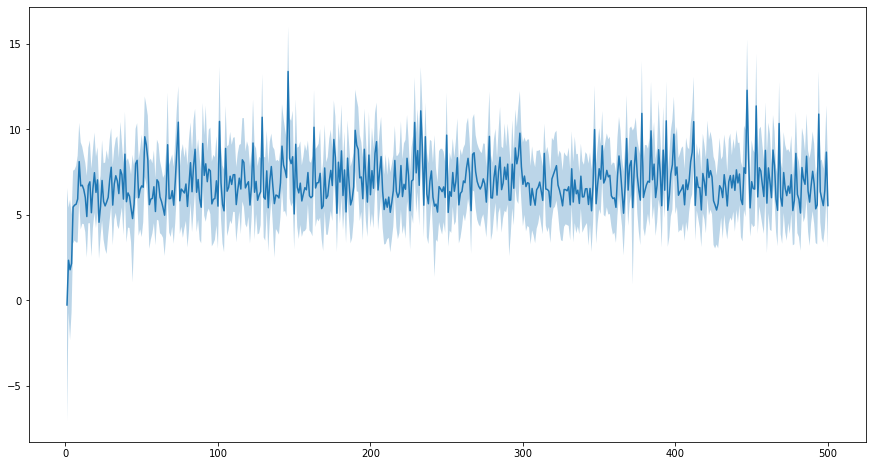

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,8))

###  Reward History

plt.plot(np.array([n+1 for n in range(len(avg_reward_list))]), np.array(avg_reward_list))
plt.fill_between(np.array([n+1 for n in range(len(avg_reward_list))]), 
                 np.array(avg_reward_list) - np.array(std_reward_list), 
                 np.array(avg_reward_list) + np.array(std_reward_list), 
                 alpha=0.3)